<h1 class="title toc-ignore" style="text-align: center;"><strong>Предсказание бросков Кобе Брайанта</strong></h1>
<p><strong><img style="display: block; margin-left: auto; margin-right: auto;" src="http://i.imgur.com/xrOu1.png" alt="" /></strong></p>
<p style="text-align: center;"><em><strong>&ldquo;Все негативное: давление, проблемы - все это дает мне возможность подняться.&rdquo;</strong></em></p>
<p style="text-align: right;"><em><strong>Кобе Брайант</strong></em></p>

# Вступление
<p style="text-align: justify;">Я большой поклонник баскетбола, и в этой статье мы проанализируем набор данных от Kaggle, содержащий позицию и обстоятельства каждого расстрела, в котором пытался забить Кобе Брайант за свою 20-летнюю карьеру.</p>
<p style="text-align: justify; padding-left: 40px;"><strong>Кобе Бин Брайант</strong> (родился 23 августа 1978 года) - американский бывший профессиональный баскетболист. Всю свою 20-летнюю карьеру он провел в составе "Лос-Анджелес Лейкерс" Национальной баскетбольной ассоциации (НБА). Он поступил в НБА прямо из средней школы и выиграл пять чемпионатов НБА с "Лейкерс". Брайант - 18-кратный чемпион всех звезд, 15-кратный член команды всех звезд НБА и 12-кратный член команды всех защитников. Он возглавлял НБА по забитым голам в течение двух сезонов и занимает третье место в лиге за все время регулярного сезона и четвертое место в списке забитых голов за все время после сезона. Он является рекордсменом НБА по количеству сезонов, проведенных с одной франшизой за всю карьеру, и широко известен как один из величайших баскетболистов всех времен. Брайант-первый защитник в истории НБА, сыгравший не менее 20 сезонов.</p>
<p style="text-align: justify;">Кстати, если вы любите баскетбол, вы также можете проверить эти другие ядра:</p>
<ul>
<li style="text-align: justify;"><a href="https://www.kaggle.com/xvivancos/michael-jordan-vs-kobe-bryant-vs-lebron-james">Michael Jordan vs Kobe Bryant vs Lebron James</a></li>
<li style="text-align: justify;"><a href="https://www.kaggle.com/xvivancos/eda-tweets-during-cavaliers-vs-warriors">EDA - Tweets during Cavaliers vs Warriors</a></li>
<li style="text-align: justify;"><a href="https://www.kaggle.com/xvivancos/how-good-is-luka-doncic">How good is Luka Doncic?</a></li></ul>
<h3><strong>Объявим необходимые библиотеки для дальнейшей работы:</strong></h3>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn import mixture
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import time
import itertools
import operator

<h4><strong>Загрузим данные и создадим несколько полезных полей</strong></h4>
<p>Показываем вновь созданные поля в качестве проверки на вменяемость.</p>

In [29]:
# Загрузка тренировочных данных
allData = pd.read_csv('..\Kobe_Bryant\input\data.csv')
data = allData[allData['shot_made_flag'].notnull()].reset_index()

# Добавляем несколько временных столбцов к данным
data['game_date_DT'] = pd.to_datetime(data['game_date'])
data['dayOfWeek']    = data['game_date_DT'].dt.dayofweek
data['dayOfYear']    = data['game_date_DT'].dt.dayofyear

data['secondsFromPeriodEnd']   = 60*data['minutes_remaining']+data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['secondsFromGameStart']   = (data['period'] <= 4).astype(int) * (data['period'] - 1) * 12 * 60 + (data['period'] > 4).astype(int) * ((data['period'] - 4) * 5 * 60 + 3 * 12 * 60) + data['secondsFromPeriodStart']

# Посмотрим на первые пару рядов и убедимся, что все хорошо
data.loc[:10,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]

,period,minutes_remaining,seconds_remaining,secondsFromGameStart
0,1,10,22,98
1,1,7,45,255
2,1,6,52,308
3,2,6,19,1061
4,3,9,32,1588
5,3,8,52,1628
6,3,6,12,1788
7,3,3,36,1944
8,3,1,56,2044
9,1,11,0,60


<h4><strong>Построение графика попыток выстрела как функции времени во время игры&nbsp;</strong></h4>
<p>Здесь мы применяем 3 различных разбиения времени и показываем попытки бросков как гистограмму от начала игры</p>

Text(0.5, 0, 'Время [Секунды от начала игры]')

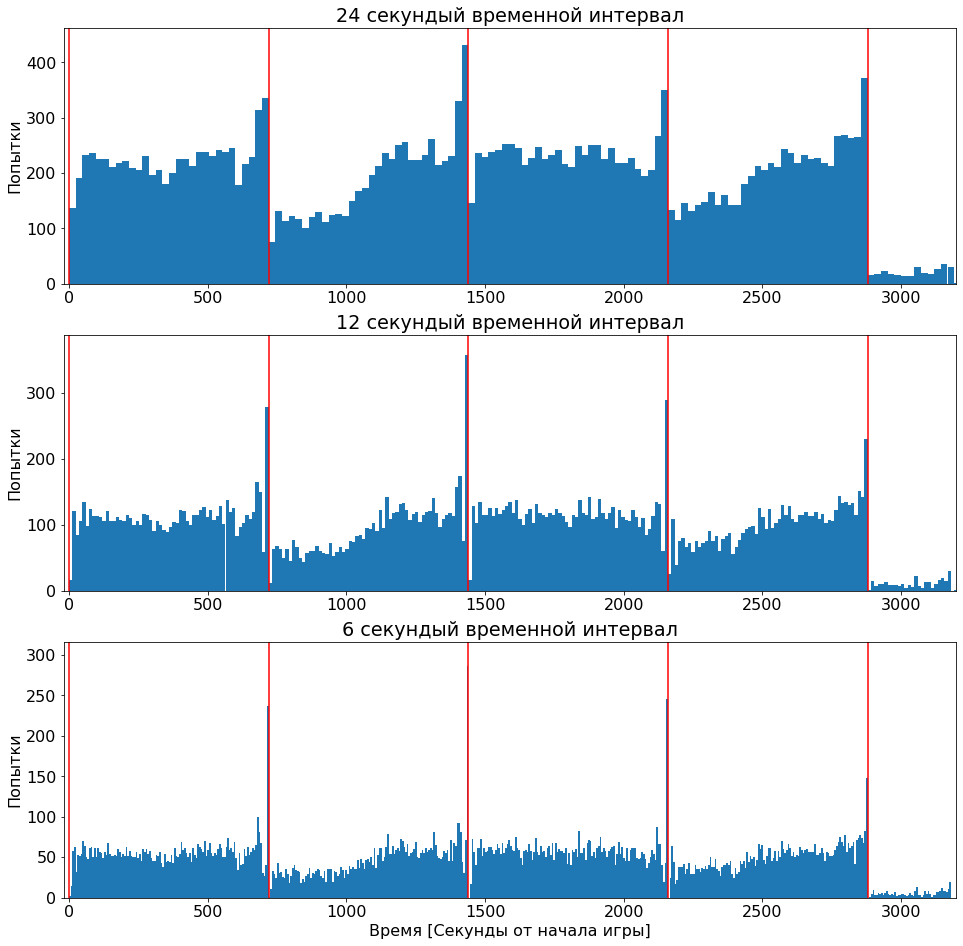

In [30]:
# Строим гистограмму попыток бросков в зависимости от времени (от начала игры) с несколькими разбиениями
plt.rcParams['figure.figsize'] = (16, 16)
plt.rcParams['font.size'] = 16

binsSizes = [24,12,6]

plt.figure();
for k, binSizeInSeconds in enumerate(binsSizes):
    timeBins = np.arange(0,60 * (4 * 12 + 3*5), binSizeInSeconds) + 0.01
    attemptsAsFunctionOfTime, b = np.histogram(data['secondsFromGameStart'], bins = timeBins)     
    
    maxHeight = max(attemptsAsFunctionOfTime) + 30
    barWidth = 0.999 * (timeBins[1] - timeBins[0])
    
    plt.subplot(len(binsSizes), 1, k + 1)
    plt.bar(timeBins[:-1], attemptsAsFunctionOfTime, align='edge', width=barWidth)
    plt.title(str(binSizeInSeconds) + ' секундый временной интервал')
    
    plt.vlines(x = [0, 12*60, 2*12*60, 3*12*60, 4*12*60], ymin = 0, ymax = maxHeight, colors = 'r')
    
    plt.xlim((-20,3200))
    plt.ylim((0,maxHeight))
    
    plt.ylabel('Попытки')
    
plt.xlabel('Время [Секунды от начала игры]')

<blockquote>
<p><em>Похоже, что Кобе доверяют делать последний выстрел в каждом периоде, а можно заметить, что он обычно находится на скамейке запасных в начале 2-ой и 4-ой четверти.</em></p>
</blockquote>

<h4><strong>Отображение точности выстрела как функции времени во время игры&nbsp;</strong></h4>

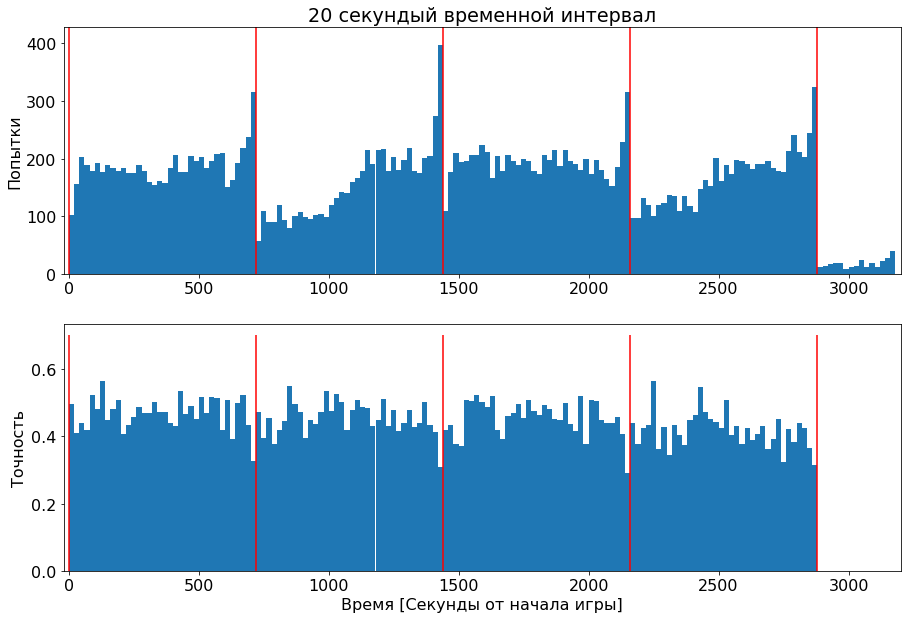

In [31]:
# Построим отображение точности как функции времени
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 16

binSizeInSeconds = 20
timeBins = np.arange(0,60 * (4*12 + 3*5),binSizeInSeconds) + 0.01
attemptsAsFunctionOfTime,     b = np.histogram(data['secondsFromGameStart'], bins = timeBins)     
madeAttemptsAsFunctionOfTime, b = np.histogram(data.loc[data['shot_made_flag'] == 1,'secondsFromGameStart'], bins=timeBins)     
attemptsAsFunctionOfTime[attemptsAsFunctionOfTime < 1] = 1
accuracyAsFunctionOfTime = madeAttemptsAsFunctionOfTime.astype(float) / attemptsAsFunctionOfTime
accuracyAsFunctionOfTime[attemptsAsFunctionOfTime <= 50] = 0 # Нулевая точность интервалов, в которых недостаточно данных

maxHeight = max(attemptsAsFunctionOfTime) + 30
barWidth = 0.999 * (timeBins[1] - timeBins[0])

plt.figure()
plt.subplot(2,1,1)
plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth)
plt.xlim((-20,3200))
plt.ylim((0,maxHeight)); plt.ylabel('Попытки')
plt.title(str(binSizeInSeconds) + ' секундый временной интервал')
plt.vlines(x = [0, 12*60, 2*12*60, 3*12*60, 4*12*60], ymin = 0, ymax = maxHeight, colors = 'r')
plt.subplot(2,1,2)
plt.bar(timeBins[:-1],accuracyAsFunctionOfTime, align='edge', width=barWidth)
plt.xlim((-20,3200))
plt.ylabel('Точность')
plt.xlabel('Время [Секунды от начала игры]')
plt.vlines(x=[0, 12*60, 2*12*60, 3*12*60, 4*12*60], ymin = 0.0,ymax = 0.7, colors='r')

<blockquote>
<p><em>Обратите внимание, что точность бросков "в последнюю секунду" неизменно ниже, чем обычно. Это можно связанать с тем, что большое количество этих бросков сделаны за линение 3 очковой дуги.</em></p>
</blockquote>

<h3 style="text-align: center;">Теперь продолжим наше первоначальное исследование и рассмотрим аспект пространственного расположения бросков Кобе</h3>
<p>Мы сделаем это, построив гауссовскую модель смеси, которая пытается компактно резюмировать места выстрелов Кобе</p>

In [32]:
# Группа попыток бросков Кобе, используя "Обобщённый метод моментов" на их месте
numGaussians = 13
gaussianMixtureModel = mixture.GaussianMixture(n_components=numGaussians, covariance_type='full', 
                                               init_params='kmeans', n_init=50, 
                                               verbose=0, random_state=5)
gaussianMixtureModel.fit(data.loc[:,['loc_x','loc_y']])

# add the GMM cluster as a field in the dataset
data['shotLocationCluster'] = gaussianMixtureModel.predict(data.loc[:,['loc_x','loc_y']])

<h4>Определите некоторые вспомогательные функции</h4>
<p>функция draw_court() бесстыдно украдена из превосходного скрипта Михаэля Крюгера)</p>

In [33]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # Если объект axes не предусмотрен для построения графика, просто получите текущий
    if ax is None:
        ax = plt.gca()

    # Создайте различных частей баскетбольной площадки НБА

    # Создание баскетбольного кольцо
    
    # Диаметр обруча составляет 18 дюймов, поэтому он имеет радиус 9 дюймов, 
    # что является значением 7.5 в нашей системе координат
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Сощдание баскетбольного щита
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # Отрисовка
    
    # Создание внещней коробки, шириной = 16ft, высотой = 19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    
    # Создание внутренней коробки, шириной = 12ft, высотой = 19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Создание верхней дуги штрафного броска
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    
    # Создание нижней дуги штрафного броска
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    
    # Зона ограниченного доступа, это дуга радиусом 4 фута от центра обруча.
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Трехочковая линия
    # Создайте трехочковой линии, она имет длину 14 футов.
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    
    # Трехочковая дуга - центром дуги будет обруч, сама дуга находится на расстоянии 23 футов 9 дюймов от обруча
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Центральный корт
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # Перечень элементов площадки для нанесения на оси
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Отрисовка центарльной, базовой и боковой линии 
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Добавьление элементы площадки на оси
    for element in court_elements:
        ax.add_patch(element)

    return ax

def Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages):
    
    fig, h = plt.subplots();
    for i, (mean, covarianceMatrix) in enumerate(zip(gaussianMixtureModel.means_, gaussianMixtureModel.covariances_)):
        
        # Получить собственные векторы и собственные значения ковариационной матрицы
        v, w = np.linalg.eigh(covarianceMatrix)
        v = 2.5*np.sqrt(v) # Переход к единицам стандартного отклонения вместо дисперсии
        
        # Вычисление уголов эллипса и длин двух осей и их отрисовка
        u = w[0] / np.linalg.norm(w[0])    
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # Конвертиртация в градусы
        currEllipse = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=ellipseColors[i])
        currEllipse.set_alpha(0.5)
        h.add_artist(currEllipse)
        h.text(mean[0]+7, mean[1]-1, ellipseTextMessages[i], fontsize=13, color='blue')

<h4>Отрисовка двумерных гауссиан попыток бросков</h4>
<p>Каждый эллипс - это контур, который представляет собой 2,5 стандартных отклонения от центра гауссианы. Каждое число синего цвета представляет процент бросков, сделанных с помощью этого гауссиана, от всех бросков.</p>

Text(0.5, 1.0, 'Броски')

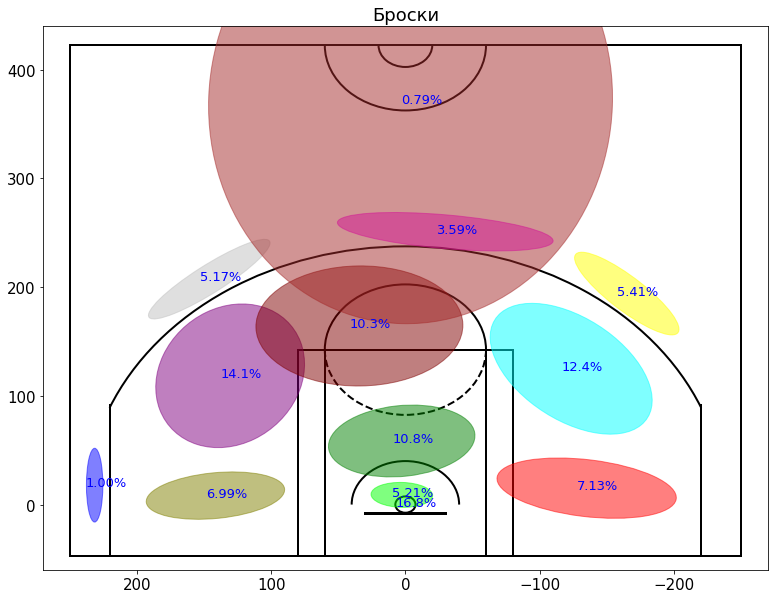

In [34]:
# Отображение эллипсов гауссовой смеси попыток бросков
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

ellipseTextMessages = [str(100*gaussianMixtureModel.weights_[x])[:4]+'%' for x in range(numGaussians)]
ellipseColors = ['red','green','purple','cyan','magenta','yellow','blue','orange','silver','maroon','lime','olive','brown','darkblue']
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270)
plt.title('Броски')

<blockquote>
<p>Мы видим, что Кобе делает больше попыток с <strong>левой стороны</strong> поля(или с <strong>правой стороны</strong>, с его точки зрения). Это вероятно потому, что он <strong>правша</strong>.</p>
<p>Также мы видим, что огромное количество попыток (16,8%) происходит непосредственно из-под корзины, а 5,06% дополнительных попыток - из очень близких к корзине.</p>
</blockquote>

<h4>Точечная диаграмма всех попыток броска Кобе, окрашенные с назначением группы в соответствии с "Обобщённый метод моментов"</h4>
<p>Убедимся, что гауссовская модель действительно что-то фиксирует.</p>

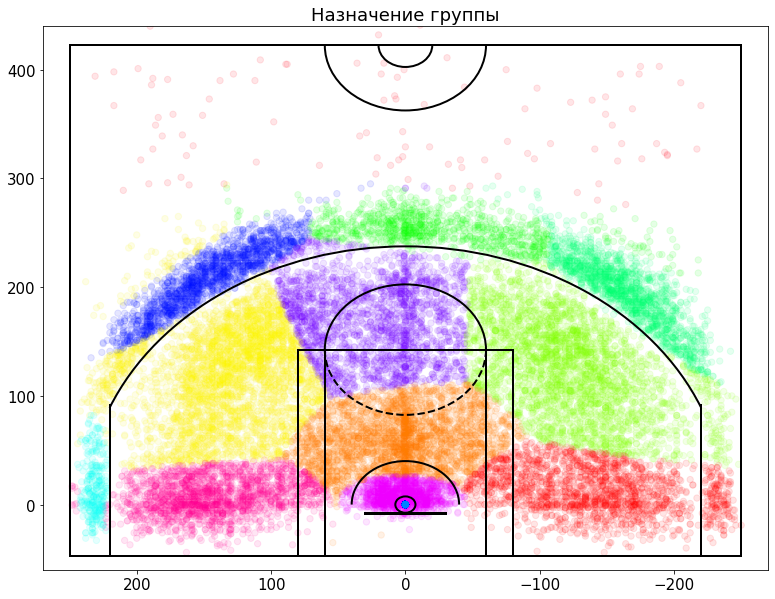

In [35]:
# Покажим распределение разброса и группы
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

plt.figure(); draw_court(outer_lines=True)
plt.ylim(-60,440)
plt.xlim(270,-270)
plt.title('Назначение группы')
plt.scatter(x = data['loc_x'], y = data['loc_y'], c = data['shotLocationCluster'], s = 40, cmap = 'hsv', alpha = 0.1)

<blockquote>
<p>Хоть данное представление не раскрывает весь поатциал имеющих данных, но определенно можно заметить некоторые интересные вещи. Например, видно, что большое и очень далекое скопление захватывает все очень далекие броски.</p>
</blockquote>

<h4>Построение графика точности бросков каждой гауссовской группы</h4>
<p>Каждое синее число здесь будет представлять точность броска, сделанных из этого кластера, чтобы мы могли почувствовать, какие броски простые, а какие сложные для Кобе.</p>

Text(0.5, 1.0, 'Точность броскаy')

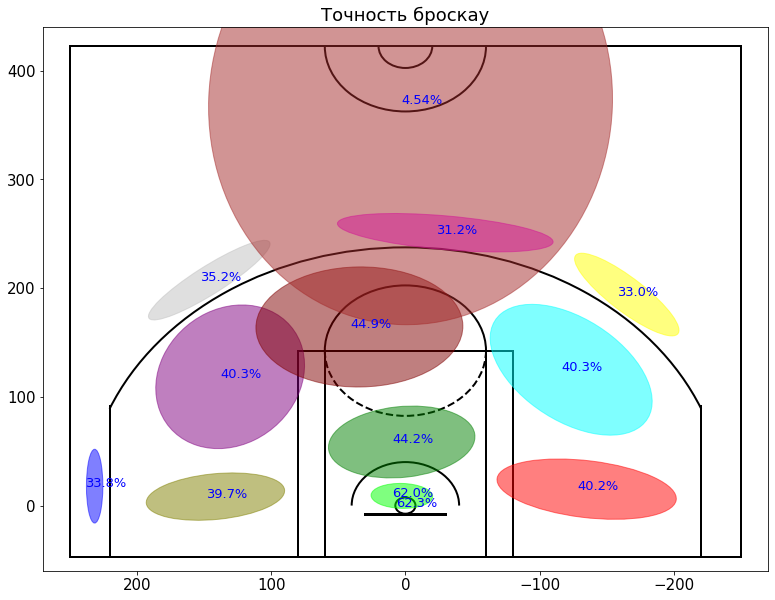

In [36]:
# Для каждой группы рассчитаем ее индивидуальную точность и построим
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

variableCategories = data['shotLocationCluster'].value_counts().index.tolist()

clusterAccuracy = {}
for category in variableCategories:
    shotsAttempted = np.array(data['shotLocationCluster'] == category).sum()
    shotsMade = np.array(data.loc[data['shotLocationCluster'] == category,'shot_made_flag'] == 1).sum()
    clusterAccuracy[category] = float(shotsMade)/shotsAttempted

ellipseTextMessages = [str(100*clusterAccuracy[x])[:4]+'%' for x in range(numGaussians)]
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('Точность броскаy')

<blockquote>
<p id="We-can-clearly-see-the-dependence-between-distance-and-accuracy">Мы можем ясно видеть зависимость между расстоянием и точностью.<br />Еще один интересный факт заключается в том, что Кобе не только делает больше попыток с правой стороны (с его точки зрения), но и реализовывает эти попытки лучше.</p>
</blockquote>

<h4 id="We-can-clearly-see-the-dependence-between-distance-and-accuracy">Теперь давайте построим двухмерный пространственно-временной график карьеры Кобе.</h4>
<ul>
<li>по оси X будет время с момента начала игры</li>
<li>по оси Y будет индекс группы, которой Кобе сделал бросок (отсортированный по точности группы)</li>
<li>интенсивностью будет количество попыток Кобе из этой конкретной группы в это конкретное время</li>
<li>красные вертикальные линии - конец каждого периода</li>
</ul>

Text(0, 0.5, 'Группа (отсортировано по точности)')

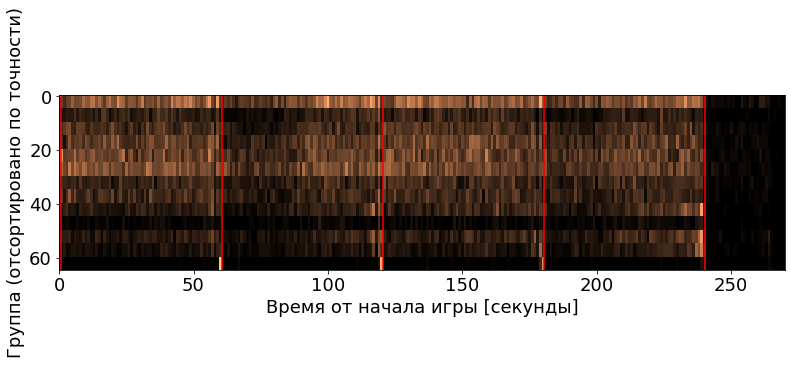

In [37]:
# Строим 2-мерную пространственно-временную гистограмму игр Кобе на протяжении всей его карьеры.
plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['font.size'] = 18

# Сортировка группы по их точности
sortedClustersByAccuracyTuple = sorted(clusterAccuracy.items(), key=operator.itemgetter(1),reverse=True)
sortedClustersByAccuracy = [x[0] for x in sortedClustersByAccuracyTuple]

binSizeInSeconds = 12
timeInUnitsOfBins = ((data['secondsFromGameStart']+0.0001)/binSizeInSeconds).astype(int)
locationInUintsOfClusters = np.array([sortedClustersByAccuracy.index(data.loc[x,'shotLocationCluster']) for x in range(data.shape[0])])

# Построим пространственно-временную гистограмму игр Кобе
shotAttempts = np.zeros((gaussianMixtureModel.n_components,1+max(timeInUnitsOfBins)))
for shot in range(data.shape[0]):
    shotAttempts[locationInUintsOfClusters[shot],timeInUnitsOfBins[shot]] += 1

# Делаем ось Y большей площадью, чтобы она была более заметной
shotAttempts = np.kron(shotAttempts,np.ones((5,1)))

# Отрисовываем линии для визуального представления окончания четверти
vlinesList = 0.5001 + np.array([0, 12*60, 2*12*60, 3*12*60, 4*12*60]).astype(int) / binSizeInSeconds

plt.figure(figsize=(13,8))
plt.imshow(shotAttempts, cmap = 'copper', interpolation = "nearest")
plt.xlim(0, float(4*12*60 + 6*60) / binSizeInSeconds)
plt.vlines(x = vlinesList, ymin = -0.5, ymax = shotAttempts.shape[0] - 0.5, colors='r')
plt.xlabel('Время от начала игры [секунды]')
plt.ylabel('Группа (отсортировано по точности)')

<p id="We-can-clearly-see-the-dependence-between-distance-and-accuracy">Группы отсортированы в порядке убывания точности. Под базой вверху находятся броски высокой точности, а внизу - броски низкой точности с половины поля.</p>
<blockquote>
<p>Теперь мы видим, что в &laquo;последние секунды&raquo; 1-ой, 2-ой и 3-ей четветри в основном были &laquo;отчаяные броски&raquo; с дальнего расстояния.</p>
<p>Однако интересно отметить, что в 4-ой четверти броски на последней секунде принадлежит не к &laquo;отчаяной&raquo; группе, а скорее обычному 3-очковой группе(которые все еще трудные, но не отчаяные).</p>
</blockquote>

<h4 id="We-can-clearly-see-the-dependence-between-distance-and-accuracy">Для последующего анализа неоходимо оценить сложность броска на основе свойств самих бросков.</h4>
<p>(Например, тип выстрела и расстояние выстрела)</p>

In [38]:
# Создание новой таблицы для модели сложности броска
def FactorizeCategoricalVariable(inputDB,categoricalVarName):
    opponentCategories = inputDB[categoricalVarName].value_counts().index.tolist()
    
    outputDB = pd.DataFrame()
    for category in opponentCategories:
        featureName = categoricalVarName + ': ' + str(category)
        outputDB[featureName] = (inputDB[categoricalVarName] == category).astype(int)

    return outputDB

featuresDB = pd.DataFrame()
featuresDB['homeGame'] = data['matchup'].apply(lambda x: 1 if (x.find('@') < 0) else 0)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'opponent')], axis = 1)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'action_type')], axis = 1)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'shot_type')], axis = 1)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'combined_shot_type')], axis = 1)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'shot_zone_basic')], axis = 1)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'shot_zone_area')], axis = 1)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'shot_zone_range')], axis = 1)
featuresDB = pd.concat([featuresDB,FactorizeCategoricalVariable(data,'shotLocationCluster')], axis = 1)

featuresDB['playoffGame']          = data['playoffs']
featuresDB['locX']                 = data['loc_x']
featuresDB['locY']                 = data['loc_y']
featuresDB['distanceFromBasket']   = data['shot_distance']
featuresDB['secondsFromPeriodEnd'] = data['secondsFromPeriodEnd']

featuresDB['dayOfWeek_cycX']  = np.sin(2*np.pi*(data['dayOfWeek'] / 7))
featuresDB['dayOfWeek_cycY']  = np.cos(2*np.pi*(data['dayOfWeek'] / 7))
featuresDB['timeOfYear_cycX'] = np.sin(2*np.pi*(data['dayOfYear'] / 365))
featuresDB['timeOfYear_cycY'] = np.cos(2*np.pi*(data['dayOfYear'] / 365))

labelsDB = data['shot_made_flag']

<h4>Попробуем построить модель на основе таблицы featuresDB и убедимся, что она не слишком подходит</h4>
<p>(То есть ошибка обучения и ошибка теста - это одно и то же)<br />Для этого используйте ExtraTreesClassifier</p>

In [39]:
# Построим простую модель и убедимся, что она не слишком подходит
randomSeed = 1
numFolds   = 4

stratifiedCV = model_selection.StratifiedKFold(n_splits=numFolds, shuffle=True, random_state=randomSeed)

mainLearner = ensemble.ExtraTreesClassifier(n_estimators=500, max_depth=5, 
                                            min_samples_leaf=120, max_features=120, 
                                            criterion='entropy', bootstrap=False, 
                                            n_jobs=-1, random_state=randomSeed)

startTime = time.time()
trainAccuracy = []; validAccuracy = [];
trainLogLosses = []; validLogLosses = []
for trainInds, validInds in stratifiedCV.split(featuresDB, labelsDB):
    # Разделить на тренировочные и действительные наборы
    X_train_CV = featuresDB.iloc[trainInds,:]
    y_train_CV = labelsDB.iloc[trainInds]
    X_valid_CV = featuresDB.iloc[validInds,:]
    y_valid_CV = labelsDB.iloc[validInds]
    
    # Обучение
    mainLearner.fit(X_train_CV, y_train_CV)
    
    # Делаем предсказания
    y_train_hat_mainLearner = mainLearner.predict_proba(X_train_CV)[:,1]
    y_valid_hat_mainLearner = mainLearner.predict_proba(X_valid_CV)[:,1]

    # Сохраняем результаты
    trainAccuracy.append(accuracy(y_train_CV, y_train_hat_mainLearner > 0.5))
    validAccuracy.append(accuracy(y_valid_CV, y_valid_hat_mainLearner > 0.5))
    trainLogLosses.append(log_loss(y_train_CV, y_train_hat_mainLearner))
    validLogLosses.append(log_loss(y_valid_CV, y_valid_hat_mainLearner))

print("-----------------------------------------------------")
print("Общая (train,valid) Точность = (%.5f,%.5f). Взята за %.2f минуты" % (np.mean(trainAccuracy),np.mean(validAccuracy), (time.time()-startTime)/60))
print("Общая (train,valid) Потеря = (%.5f,%.5f). Взята за %.2f минуты" % (np.mean(trainLogLosses),np.mean(validLogLosses), (time.time()-startTime)/60))
print("-----------------------------------------------------")

-----------------------------------------------------
Общая (train,valid) Точность = (0.67942,0.67852). Взята за 0.22 минуты
Общая (train,valid) Потеря = (0.60817,0.61098). Взята за 0.22 минуты
-----------------------------------------------------


<p>Добавляем поле &laquo;Сложность выстрела&raquo; к каждой исходной записи броска.</p>
<p>(Которая на самом деле является прогнозируемой вероятностью выполнения броска. Это означает, что название сейчас немного сбивает с толку)</p>

In [40]:
mainLearner.fit(featuresDB, labelsDB)
data['shotDifficulty'] = mainLearner.predict_proba(featuresDB)[:,1]

<h4>Заметим важные особенности этой модели.</h4>
<p>Рассмотрим важность функций согласно классификатору ET.</p>

In [41]:
# Получим представление о том, что определяет сложность броска, посмотрим на важность функций
featureInds = mainLearner.feature_importances_.argsort()[::-1]
featureImportance = pd.DataFrame(np.concatenate((featuresDB.columns[featureInds,None], 
                                                 mainLearner.feature_importances_[featureInds,None]), axis=1), 
                                                     columns=['featureName', 'importanceET'])

featureImportance.iloc[:30,:]

<ipython-input-41-72055be6e0b0>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  featureImportance = pd.DataFrame(np.concatenate((featuresDB.columns[featureInds,None],


,featureName,importanceET
0,action_type: Jump Shot,0.575144
1,action_type: Layup Shot,0.17293
2,combined_shot_type: Dunk,0.113231
3,homeGame,0.0284773
4,shotLocationCluster: 12,0.0191072
5,action_type: Dunk Shot,0.0163783
6,combined_shot_type: Layup,0.00925421
7,distanceFromBasket,0.00775376
8,shot_zone_range: 16-24 ft.,0.00722875
9,action_type: Slam Dunk Shot,0.00656714


<h3 style="text-align: center;">Попробуем получить доступ к некоторым аспектам процесса принятия решений Кобе Брайанта.</h3>
<h4 id="For-that-we-will-collect-two-distinct-groups-of-shots-and-analyse-the-differences-between-them:">Для этого мы соберем две отдельные группы бросков и проанализируем различия между ними:</h4>
<ol>
<li>Броски, которые последовали сразу <strong>после удачной попытки</strong>.</li>
<li>Броски, которые последовали сразу <strong>после промоха</strong>.</li>
</ol>

In [42]:
# Сбор данных с учетом того, что Кобе попал или промахнулся в последнем броске
timeBetweenShotsDict = {}
timeBetweenShotsDict['madeLast']   = []
timeBetweenShotsDict['missedLast'] = []

changeInDistFromBasketDict = {}
changeInDistFromBasketDict['madeLast']   = []
changeInDistFromBasketDict['missedLast'] = []

changeInShotDifficultyDict = {}
changeInShotDifficultyDict['madeLast']   = []
changeInShotDifficultyDict['missedLast'] = []

afterMadeShotsList   = []
afterMissedShotsList = []

for shot in range(1, data.shape[0]):

    # Убедимся, что текущий бросок и последний бросок были сделаны в один и тот же период одной и той же игры
    sameGame   = data.loc[shot,'game_date'] == data.loc[shot-1,'game_date']
    samePeriod = data.loc[shot,'period']    == data.loc[shot-1,'period']

    if samePeriod and sameGame:
        madeLastShot       = data.loc[shot-1,'shot_made_flag'] == 1
        missedLastShot     = data.loc[shot-1,'shot_made_flag'] == 0
        
        timeDifferenceFromLastShot = data.loc[shot,'secondsFromGameStart']     - data.loc[shot-1,'secondsFromGameStart']
        distDifferenceFromLastShot = data.loc[shot,'shot_distance']            - data.loc[shot-1,'shot_distance']
        shotDifficultyDifferenceFromLastShot = data.loc[shot,'shotDifficulty'] - data.loc[shot-1,'shotDifficulty']

        # Проверка наличие поврежденных точек данных 
        # (Предполагая, что все образцы должны были быть упорядочены в хронологическом порядке)
        if timeDifferenceFromLastShot < 0:
            continue
        
        if madeLastShot:
            timeBetweenShotsDict['madeLast'].append(timeDifferenceFromLastShot)
            changeInDistFromBasketDict['madeLast'].append(distDifferenceFromLastShot)
            changeInShotDifficultyDict['madeLast'].append(shotDifficultyDifferenceFromLastShot)
            afterMadeShotsList.append(shot)
            
        if missedLastShot:
            timeBetweenShotsDict['missedLast'].append(timeDifferenceFromLastShot)
            changeInDistFromBasketDict['missedLast'].append(distDifferenceFromLastShot)
            changeInShotDifficultyDict['missedLast'].append(shotDifficultyDifferenceFromLastShot)
            afterMissedShotsList.append(shot)

afterMissedData = data.iloc[afterMissedShotsList,:]
afterMadeData   = data.iloc[afterMadeShotsList,:]

shotChancesListAfterMade = afterMadeData['shotDifficulty'].tolist()
totalAttemptsAfterMade   = afterMadeData.shape[0]
totalMadeAfterMade       = np.array(afterMadeData['shot_made_flag'] == 1).sum()

shotChancesListAfterMissed = afterMissedData['shotDifficulty'].tolist()
totalAttemptsAfterMissed   = afterMissedData.shape[0]
totalMadeAfterMissed       = np.array(afterMissedData['shot_made_flag'] == 1).sum()

<h4 style="text-align: left;">Построение гистограмм &laquo;Время с момента последней попытки броска&raquo; для двух групп.</h4>

Text(0, 0.5, 'Количество')

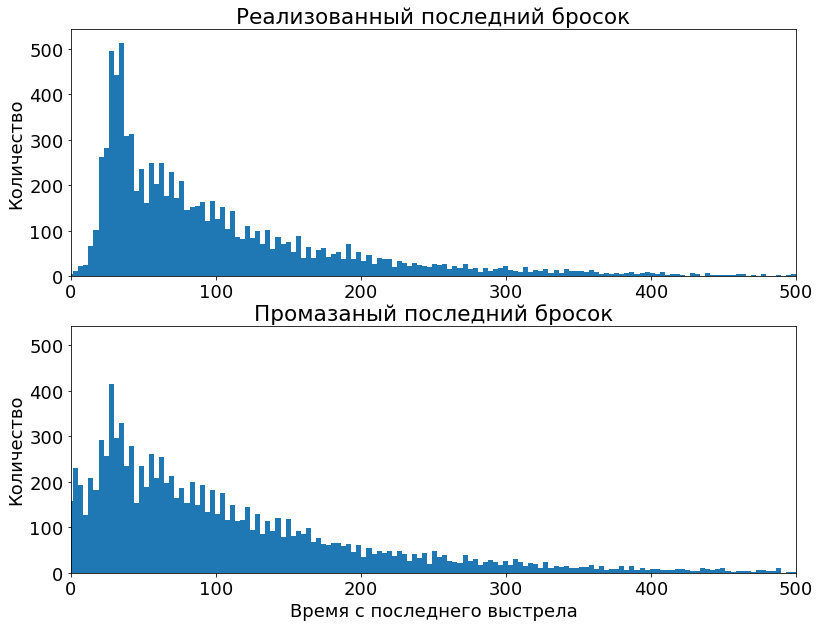

In [43]:
# Сделав бросок, Кобе хочет большего
plt.rcParams['figure.figsize'] = (13, 10)

jointHist, timeBins = np.histogram(timeBetweenShotsDict['madeLast']+timeBetweenShotsDict['missedLast'],bins=200)
barWidth = 0.999*(timeBins[1]-timeBins[0])

timeDiffHist_GivenMadeLastShot, b = np.histogram(timeBetweenShotsDict['madeLast'],bins=timeBins)
timeDiffHist_GivenMissedLastShot, b = np.histogram(timeBetweenShotsDict['missedLast'],bins=timeBins)
maxHeight = max(max(timeDiffHist_GivenMadeLastShot),max(timeDiffHist_GivenMissedLastShot)) + 30

plt.figure();
plt.subplot(2,1,1); plt.bar(timeBins[:-1], timeDiffHist_GivenMadeLastShot, width=barWidth)

plt.xlim((0,500))
plt.ylim((0,maxHeight))
plt.title('Реализованный последний бросок')
plt.ylabel('Количество')
        
plt.subplot(2,1,2)
plt.bar(timeBins[:-1], timeDiffHist_GivenMissedLastShot, width=barWidth)
          
plt.xlim((0,500))
plt.ylim((0,maxHeight))
plt.title('Промазаный последний бросок')
plt.xlabel('Время с последнего выстрела')
plt.ylabel('Количество')

<blockquote>
<p>Похоже, что после броска Кобе чуть больше хочет сделать следующий бросок</p>
<p>Всем, кто задается вопросом, почему после сделанного броска наступает &laquo;период молчания&raquo;:</p>
<p>Скорее всего, потому что мяч передается другой команде после удачного броска, и требуется некоторое время, чтобы вернуть мяч.</p>
</blockquote>

<h4>Чтобы лучше визуализировать эту разницу между гистограммами, давайте посмотрим на совокупные гистограммы.</h4>

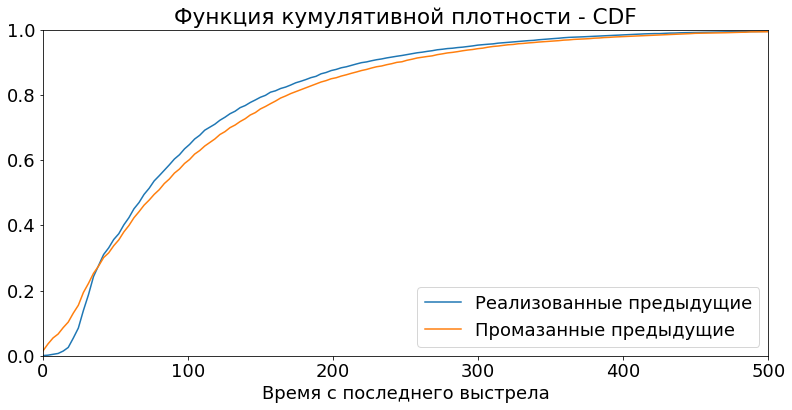

In [44]:
# Совокупность гистограмм
plt.rcParams['figure.figsize'] = (13, 6)

timeDiffCumHist_GivenMadeLastShot = np.cumsum(timeDiffHist_GivenMadeLastShot).astype(float)
timeDiffCumHist_GivenMadeLastShot = timeDiffCumHist_GivenMadeLastShot/max(timeDiffCumHist_GivenMadeLastShot)
timeDiffCumHist_GivenMissedLastShot = np.cumsum(timeDiffHist_GivenMissedLastShot).astype(float)
timeDiffCumHist_GivenMissedLastShot = timeDiffCumHist_GivenMissedLastShot/max(timeDiffCumHist_GivenMissedLastShot)

maxHeight = max(timeDiffCumHist_GivenMadeLastShot[-1],timeDiffCumHist_GivenMissedLastShot[-1])

plt.figure()
madePrev = plt.plot(timeBins[:-1], timeDiffCumHist_GivenMadeLastShot, label='Реализованные предыдущие')
plt.xlim((0,500))
missedPrev = plt.plot(timeBins[:-1], timeDiffCumHist_GivenMissedLastShot, label='Промазанные предыдущие')
plt.xlim((0,500))
plt.ylim((0,1))
plt.title('Функция кумулятивной плотности - CDF')
plt.xlabel('Время с последнего выстрела')
plt.legend(loc='lower right')

<h4>Построение гистограмм &laquo;Текущее расстояние броска - Расстояние предыдущего броска&raquo; для двух групп.</h4>
<p>Обратите внимание, что если Кобе бросает с близкого расстояния, а затем с большого расстояния, это приведет к положительным значениям &laquo;дистанция текущего броска - расстояние до броска&raquo;. и наоборот - если Кобе бросает издалека, а затем - с близкого расстояния, это приведет к отрицательным значениям.</p>

Text(0, 0.5, 'Количество')

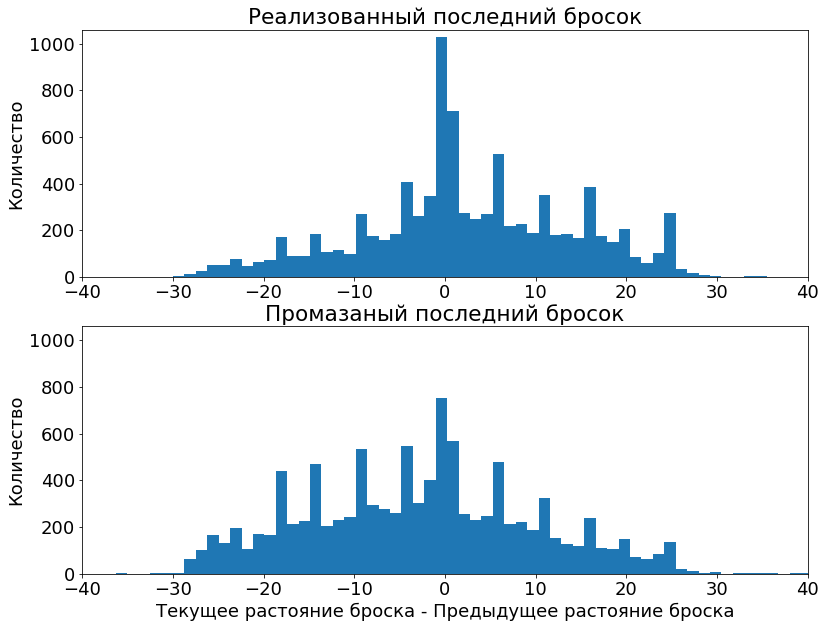

In [45]:
# После броска Кобе ведет себя более уверенно и бросает издалека
plt.rcParams['figure.figsize'] = (13, 10)

jointHist, distDiffBins = np.histogram(changeInDistFromBasketDict['madeLast']+changeInDistFromBasketDict['missedLast'],bins=100,density=False)
barWidth = 0.999*(distDiffBins[1]-distDiffBins[0])

distDiffHist_GivenMadeLastShot,   b = np.histogram(changeInDistFromBasketDict['madeLast'],bins=distDiffBins)
distDiffHist_GivenMissedLastShot, b = np.histogram(changeInDistFromBasketDict['missedLast'],bins=distDiffBins)
maxHeight = max(max(distDiffHist_GivenMadeLastShot),max(distDiffHist_GivenMissedLastShot)) + 30

plt.figure()
plt.subplot(2,1,1)
plt.bar(distDiffBins[:-1], distDiffHist_GivenMadeLastShot, width=barWidth)
plt.xlim((-40,40))
plt.ylim((0,maxHeight))
plt.title('Реализованный последний бросок')
plt.ylabel('Количество')
plt.subplot(2,1,2)

plt.bar(distDiffBins[:-1], distDiffHist_GivenMissedLastShot, width=barWidth)
plt.xlim((-40,40))
plt.ylim((0,maxHeight))
plt.title('Промазаный последний бросок')
plt.xlabel('Текущее растояние броска - Предыдущее растояние броска')
plt.ylabel('Количество')

<p>Хорошо видно, что сделанная группа бросков более <strong>наклонена вправо</strong>.</p>
<p>Таким образом, похоже, что <strong>Кобе более уверен в себе после броска, и из-за этого он больше рискует и бросает с дальней дистанции</strong>.</p>
<p>Это даже более очевидно, чем на предыдущем графике, но давайте снова построим кумулятивные гистограммы, чтобы было понятнее.</p>

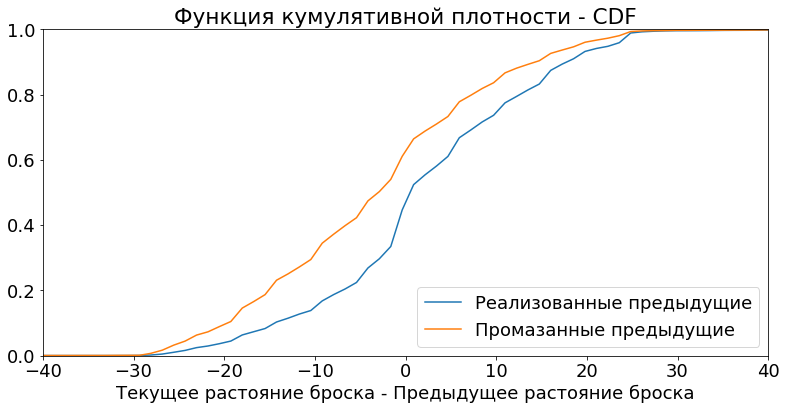

In [46]:
# Для большей ясности рассмотрим кумулятивную гистограмму
plt.rcParams['figure.figsize'] = (13, 6)

distDiffCumHist_GivenMadeLastShot = np.cumsum(distDiffHist_GivenMadeLastShot).astype(float)
distDiffCumHist_GivenMadeLastShot = distDiffCumHist_GivenMadeLastShot/max(distDiffCumHist_GivenMadeLastShot)
distDiffCumHist_GivenMissedLastShot = np.cumsum(distDiffHist_GivenMissedLastShot).astype(float)
distDiffCumHist_GivenMissedLastShot = distDiffCumHist_GivenMissedLastShot/max(distDiffCumHist_GivenMissedLastShot)

maxHeight = max(distDiffCumHist_GivenMadeLastShot[-1],distDiffCumHist_GivenMissedLastShot[-1])

plt.figure();
madePrev = plt.plot(distDiffBins[:-1], distDiffCumHist_GivenMadeLastShot, label='Реализованные предыдущие')
plt.xlim((-40,40))
missedPrev = plt.plot(distDiffBins[:-1], distDiffCumHist_GivenMissedLastShot, label='Промазанные предыдущие')
plt.xlim((-40,40))
plt.ylim((0,1))
plt.title('Функция кумулятивной плотности - CDF')
plt.xlabel('Текущее растояние броска - Предыдущее растояние броска')
plt.legend(loc='lower right')

<h4>Наконец, давайте наметим изменение &laquo;Сложности броска&raquo; для двух групп.</h4>
<p>Здесь отрицательные значения указывают на то, что Кобе взял на себя больший риск, а положительные значения указывают на то, что Кобе сделал более безопасный следующий бросок.</p>

Text(0, 0.5, 'Количество')

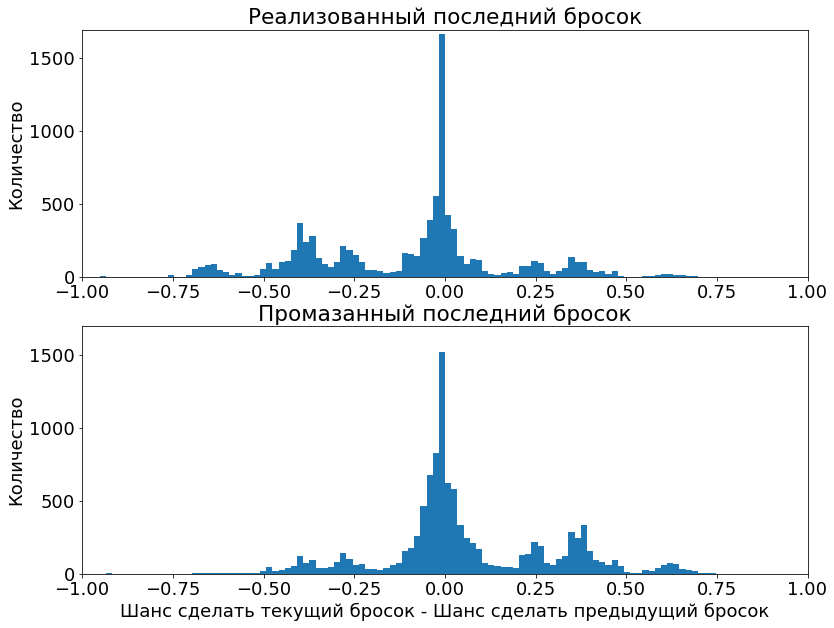

In [47]:
# После броска Кобе ведет себя более уверенно и в целом делает гораздо более сложные броски
plt.rcParams['figure.figsize'] = (13, 10)

jointHist, difficultyDiffBins = np.histogram(changeInShotDifficultyDict['madeLast']+changeInShotDifficultyDict['missedLast'],bins=100)
barWidth = 0.999*(difficultyDiffBins[1]-difficultyDiffBins[0])

shotDifficultyDiffHist_GivenMadeLastShot,   b = np.histogram(changeInShotDifficultyDict['madeLast'],bins=difficultyDiffBins)
shotDifficultyDiffHist_GivenMissedLastShot, b = np.histogram(changeInShotDifficultyDict['missedLast'],bins=difficultyDiffBins)
maxHeight = max(max(shotDifficultyDiffHist_GivenMadeLastShot),max(shotDifficultyDiffHist_GivenMissedLastShot)) + 30

plt.figure()
plt.subplot(2,1,1)
plt.bar(difficultyDiffBins[:-1], shotDifficultyDiffHist_GivenMadeLastShot, width=barWidth)
plt.xlim((-1,1))
plt.ylim((0,maxHeight))
plt.title('Реализованный последний бросок')
plt.ylabel('Количество')
plt.subplot(2,1,2)
plt.bar(difficultyDiffBins[:-1], shotDifficultyDiffHist_GivenMissedLastShot, width=barWidth)
plt.xlim((-1,1))
plt.ylim((0,maxHeight))
plt.title('Промазанный последний бросок')
plt.xlabel('Шанс сделать текущий бросок - Шанс сделать предыдущий бросок')
plt.ylabel('Количество')

<blockquote>
<h4>Видно, что слева гистограмма тяжелее.</h4>
<h4>Поэтому теперь еще более очевидно, что Кобе чувствует себя &laquo;В зоне&raquo; после броска</h4>
<p>и поэтому он позволяет себе делать более сложные попытки.</p>
</blockquote>

<h4>Некоторым из вас может быть интересно, простой ли это регресс к среднему значению или нет?</h4>
<p>Это разумная мысыль, поскольку все успешные попытки по своей сути склонны к более легким броскам, и если мы будем использовать относительные меры, такие как &laquo;изменение сложности броска&raquo;, мы обязательно получим этот эффект, просто &laquo;вернувшись к среднему значению&raquo;, поэтому нам нужно убедитесь, что это не так.</p>

Text(0.5, 1.0, 'Не регресс к среднему')

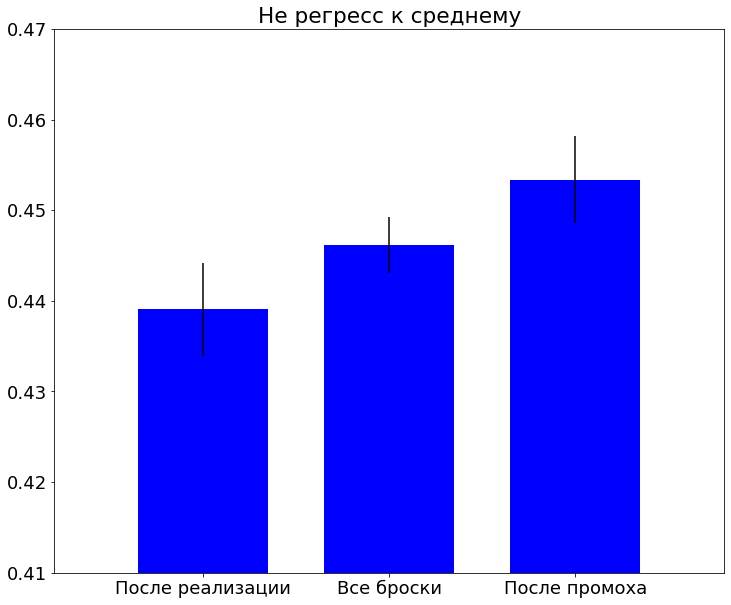

In [48]:
# Это регресс к среднему значению?
plt.rcParams['figure.figsize'] = (12, 10)

accuracyAllShots    = data['shot_made_flag'].mean()
accuracyAfterMade   = afterMadeData['shot_made_flag'].mean()
accuracyAfterMissed = afterMissedData['shot_made_flag'].mean()

standardErrorAllShots    = np.sqrt(accuracyAllShots*(1-accuracyAllShots)/data.shape[0])
standardErrorAfterMade   = np.sqrt(accuracyAfterMade*(1-accuracyAfterMade)/afterMadeData.shape[0])
standardErrorAfterMissed = np.sqrt(accuracyAfterMissed*(1-accuracyAfterMissed)/afterMissedData.shape[0])

accuracyVec = np.array([accuracyAfterMade,accuracyAllShots,accuracyAfterMissed])
errorVec    = np.array([standardErrorAfterMade,standardErrorAllShots,standardErrorAfterMissed])

barWidth = 0.7
xLocs = np.arange(len(accuracyVec)) + 0.5

fig, h = plt.subplots(); h.bar(xLocs, accuracyVec, barWidth, color='b', yerr=errorVec)
h.set_xticks(xLocs)
h.set_xticklabels(('После реализации', 'Все броски', 'После промоха'))
plt.ylim([0.41,0.47])
plt.xlim([-0.3,3.3])
plt.title('Не регресс к среднему')

<h4>Итак, теперь мы установили, что это не просто регрессия к среднему значению, и что на самом деле существуют две разные группы бросков с очень разной точностью, возникает вопрос:</h4>

<h3 style="text-align: center;">Прав ли Кобе в своем чувстве &laquo;Горячей руки&raquo;?</h3>
<p>Может быть, Кобе действительно &laquo;в зоне&raquo;, и поэтому для него &laquo;нормально&raquo; выполнять более сложные броски?</p>

In [49]:
#%% but wait, maybe kobe is making more difficult shots because he's "in the zone"

predictedShotPercentAfterMade = np.array(shotChancesListAfterMade).mean()
predictedStadardDev = np.sqrt(predictedShotPercentAfterMade*(1-predictedShotPercentAfterMade))
stadardError = predictedStadardDev/np.sqrt(len(shotChancesListAfterMade))
predPlusErr  = predictedShotPercentAfterMade + 2*stadardError
predMinusErr = predictedShotPercentAfterMade - 2*stadardError
actualShotPercentAfterMade = float(totalMadeAfterMade)/totalAttemptsAfterMade

print("-----------------------------------------------------")
print('При условии, что Кобе РЕАЛИЗОВАЛ предыдущий выстрел:')
print('Согласно модели "shotDifficulty", 95% доверительный интервал ['+ str(predMinusErr)+', '+str(predPlusErr)+']')
print('и Кобе действительно сделал ' + str(actualShotPercentAfterMade) + ', который находится в пределах доверительного интервала')
print("-----------------------------------------------------")

predictedShotPercentAfterMissed = np.array(shotChancesListAfterMissed).mean()
predictedStadardDev = np.sqrt(predictedShotPercentAfterMissed*(1-predictedShotPercentAfterMissed))
stadardError = predictedStadardDev/np.sqrt(len(shotChancesListAfterMissed))
predPlusErr  = predictedShotPercentAfterMissed + 2*stadardError
predMinusErr = predictedShotPercentAfterMissed - 2*stadardError
actualShotPercentAfterMissed = float(totalMadeAfterMissed)/totalAttemptsAfterMissed

print("-----------------------------------------------------")
print('При условии, что Кобе ПРОМАЗАЛ предыдущий выстрел:')
print('Согласно модели "shotDifficulty", 95% доверительный интервал ['+ str(predMinusErr)+', '+str(predPlusErr)+']')
print('и Кобе действительно сделал' + str(actualShotPercentAfterMissed) + ', который находится в пределах доверительного интервала')
print("-----------------------------------------------------")

-----------------------------------------------------
При условии, что Кобе РЕАЛИЗОВАЛ предыдущий выстрел:
Согласно модели "shotDifficulty", 95% доверительный интервал [0.4256963063383305, 0.4463922183184032]
и Кобе действительно сделал 0.4390376660134988, который находится в пределах доверительного интервала
-----------------------------------------------------
-----------------------------------------------------
При условии, что Кобе ПРОМАЗАЛ предыдущий выстрел:
Согласно модели "shotDifficulty", 95% доверительный интервал [0.44477884244976423, 0.46409733216691224]
и Кобе действительно сделал0.45338225609182425, который находится в пределах доверительного интервала
-----------------------------------------------------


<blockquote><h4>Мы видим, что точность полностью объясняется созданной нами моделью &laquo;shotDifficulty&raquo;, которая не содержит никаких функций, связанных с горячими руками.</h4>
</blockquote>

<h3>Похоже, ответ заключается в том, что у Кобе нет эффекта &laquo;Горячей руки&raquo;.</h3>
<p>Давайте теперь попытаемся визуализировать это немного лучше</p>

(270.0, -270.0)

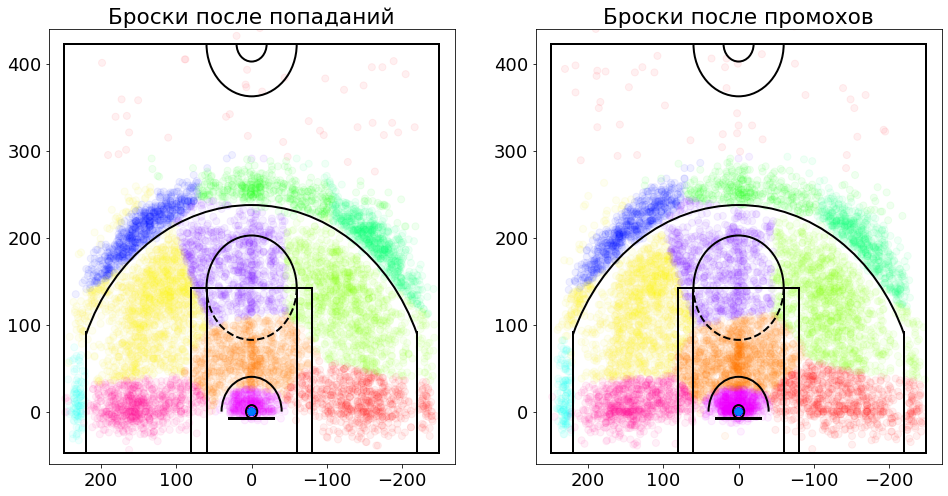

In [50]:
# Давайте попробуем визуализировать это - показать точечную диаграмму после реализованых и после промазаных бросков
plt.rcParams['figure.figsize'] = (16, 8)

afterMissedData = data.iloc[afterMissedShotsList,:]
afterMadeData = data.iloc[afterMadeShotsList,:]

plt.figure()
plt.subplot(1,2,1)
plt.title('Броски после попаданий')
plt.scatter(x=afterMadeData['loc_x'],y=afterMadeData['loc_y'],c=afterMadeData['shotLocationCluster'],s=50,cmap='hsv',alpha=0.06)
draw_court(outer_lines=True)
plt.ylim(-60,440)
plt.xlim(270,-270);

plt.subplot(1,2,2)
plt.title('Броски после промохов');
plt.scatter(x=afterMissedData['loc_x'],y=afterMissedData['loc_y'],c=afterMissedData['shotLocationCluster'],s=50,cmap='hsv',alpha=0.06)
draw_court(outer_lines=True)
plt.ylim(-60,440)
plt.xlim(270,-270)

<blockquote>
<p>Если внимательно примотреться можно увидить здесь различия в плотности, но это не очень очевидное отличие, поэтому давайте покажем данные в формате Гаусса, надеясь, что они будут более четкими.</p>
</blockquote>

Text(0.5, 1.0, 'Броски после промохов')

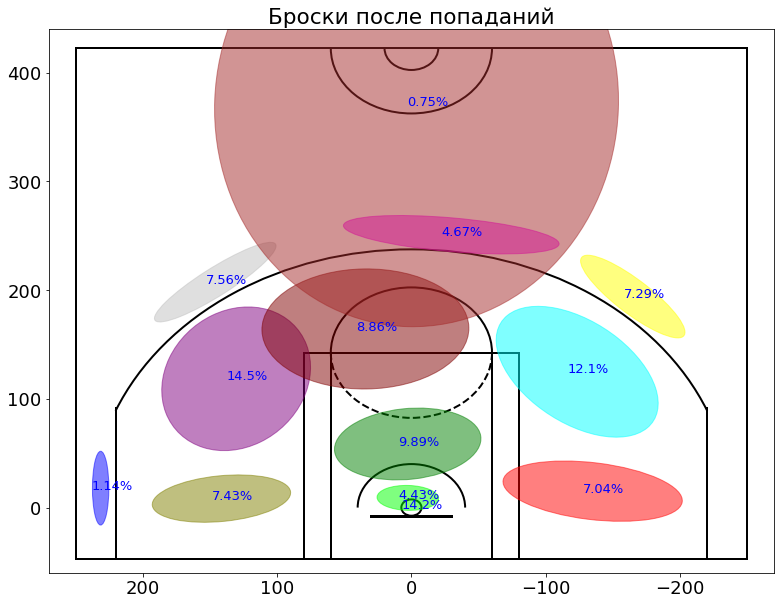

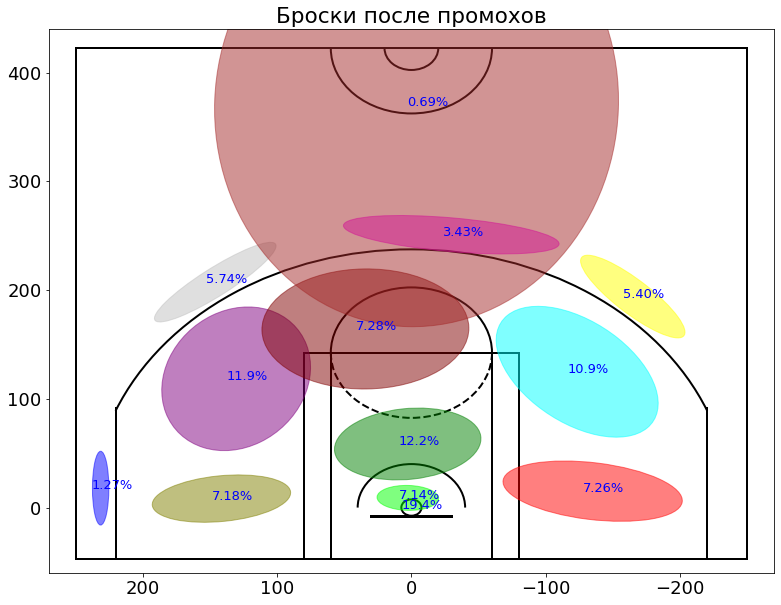

In [51]:
# Отрисуем попытки бросков после реализованых и после промазаных бросков
plt.rcParams['figure.figsize'] = (13, 10)

variableCategories = afterMadeData['shotLocationCluster'].value_counts().index.tolist()
clusterFrequency = {}
for category in variableCategories:
    shotsAttempted = np.array(afterMadeData['shotLocationCluster'] == category).sum()
    clusterFrequency[category] = float(shotsAttempted)/afterMadeData.shape[0]

ellipseTextMessages = [str(100*clusterFrequency[x])[:4]+'%' for x in range(numGaussians)]
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('Броски после попаданий')

variableCategories = afterMissedData['shotLocationCluster'].value_counts().index.tolist()
clusterFrequency = {}
for category in variableCategories:
    shotsAttempted = np.array(afterMissedData['shotLocationCluster'] == category).sum()
    clusterFrequency[category] = float(shotsAttempted)/afterMissedData.shape[0]

ellipseTextMessages = [str(100*clusterFrequency[x])[:4]+'%' for x in range(numGaussians)]
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('Броски после промохов')

<blockquote>
<h4>Теперь совершенно очевидно, что после промаха Кобе с гораздо большей вероятностью бросит из под кольца, чем после попадания (27% после промаха предыдущего броска против 18% после того реализованного бросока).</h4>
<h4>Также очевидно, что после того, как Кобе сделалает удачный бросок, он с гораздо большей вероятностью попробует реализовать 3-х очковый в качестве своего следующего броска.</h4>
</blockquote>